In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install POT==0.4.0 -q
!pip install --upgrade numpy -q
!pip install scipy==1.2.0 -q
!pip install tqdm==4.19.6 -q
!pip install torch==0.4.1.post2 -q
!pip install torchvision==0.2.1 -q
!pip install umap-learn -q

In [4]:
import math
import os
import timeit
import math

import numpy as np
import ot
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import pdb
from tqdm import tqdm
import matplotlib.pyplot as pltda

from scipy.stats import entropy
from numpy.linalg import norm
from scipy import linalg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [54]:
from __future__ import print_function, unicode_literals
import os

import tensorflow as tf
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

class BinaryDbReader(Dataset):
    """
        Reads data from a binary dataset created by create_binary_db.py
    """
    def __init__(self, file, transform=None):
        self.transform = transform
        self.path_to_db = './hand3d/data/bin/' + file
        
        if os.path.getsize(self.path_to_db) % 16840 == 0:
            self.num_samples = os.path.getsize(self.path_to_db) // 16840
        else:
            assert 0, "Binary file does not divide evenly into 16840!!"

        assert os.path.exists(self.path_to_db), "Could not find the binary data file!"

        #self.dataset = tf.data.FixedLengthRecordDataset(self.path_to_db, record_bytes=16840)
        #self.iter = self.dataset.as_numpy_iterator()

        #for i in range(start_idx):
         #   self.iter.next()

        # these are constants of the dataset and therefore must not be changed
        self.image_size = (64, 64)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """ READ DATA ITEMS"""
        img_bytes = np.fromfile(self.path_to_db, dtype=np.uint8,
                                count=16840, offset=idx*16840)
        img = img_bytes[435:12723].reshape(64,64,3)

        # img_bytes = self.iter.next()[435:12723]
        # img = np.frombuffer(img_bytes, dtype=np.uint8)
        # img = img.reshape(64,64,3)
        return self.transform(img)

In [55]:
def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)


def sample(dataset, sampleSize, batchSize, saveFolder, workers=4):
    print('sampling ...')
    saveFolder = saveFolder + '0/'

    dataloader = torch.utils.data.DataLoader(
        dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))
    if not os.path.exists(saveFolder):
        try:
            os.makedirs(saveFolder)
        except OSError:
            pass
    iter = 0
    for i, img in enumerate(dataloader, 0):
        for j in range(0, len(img)):
            vutils.save_image(img[j].mul(0.5).add(
                0.5), saveFolder + giveName(iter) + ".png")
            iter += 1
            if iter >= sampleSize:
                break
        if iter >= sampleSize:
            break
        print(f'batch {i} complete')


class ConvNetFeatureSaver(object):
    def __init__(self, model='resnet34', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, save2disk=False):
        dataset = dset.ImageFolder(root=imgFolder, transform=self.trans)
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, num_workers=self.workers)
        print('extracting features...')
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []
        for img, _ in tqdm(dataloader):
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'vgg' or self.model == 'vgg16':
                    fconv = self.vgg.features(input).view(input.size(0), -1)
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        if save2disk:
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_pixl.pth'))
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_conv.pth'))
            torch.save(feature_logit, os.path.join(
                imgFolder, 'feature_logit.pth'))
            torch.save(feature_smax, os.path.join(
                imgFolder, 'feature_smax.pth'))

        return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1)
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1)
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_real = s.tp / (s.tp + s.fn)
    s.acc_fake = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem*torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e



eps = 1e-20
def inception_score(X):
    kl = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score

def mode_score(X, Y):
    kl1 = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0)+eps).log()-(Y.mean(0)+eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
        np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


def compute_score_raw(dataset_r, dataset_f, sampleSize, batchSize, saveFolder_r, saveFolder_f,
                      conv_model='resnet34', workers=4):

    sample(dataset_r, sampleSize, batchSize, saveFolder_r, workers)
    sample(dataset_f, sampleSize, batchSize, saveFolder_f, workers)
    print('sampling completed')

    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    feature_r = convnet_feature_saver.save(saveFolder_r)
    feature_f = convnet_feature_saver.save(saveFolder_f)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(4 * 7 + 3)
    for i in range(0, 4):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_real, tmp.acc_fake, tmp.precision, tmp.recall

    score[28] = inception_score(feature_f[3])
    score[29] = mode_score(feature_r[3], feature_f[3])
    score[30] = fid(feature_r[3], feature_f[3])
    return score

In [7]:
%cd 'drive/MyDrive/Colab Notebooks/Project'

/content/drive/MyDrive/Colab Notebooks/Project


In [56]:
versions = ['rhd_raw','rhd','vaegan','cyclegan_auth','cyclegan_disc','freihand']

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
real_dataset = BinaryDbReader('freihand_training.bin', transform)

for v in versions:
    for i in range(5):
        print(f'{v} iteration {i}')
        fake_dataset = BinaryDbReader(v+'_training.bin', transform)

        score = compute_score_raw(real_dataset, fake_dataset, 12800, 512,
                          'real/', 'fake/', workers=4)
        
        if not os.path.exists(f'scores/{v}/'):
            try:
                os.makedirs(f'scores/{v}/')
            except OSError:
                pass

        np.save(f'scores/{v}/{i}.npy', score)

rhd_raw iteration 0
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling completed


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


compute score in space: 0


/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:204: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd_raw iteration 1
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [01:57<00:00,  4.70s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd_raw iteration 2
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampli

  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [01:57<00:00,  4.70s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd_raw iteration 3
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [01:54<00:00,  4.56s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd_raw iteration 4
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [01:57<00:00,  4.69s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd iteration 0
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [01:39<00:00,  3.98s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd iteration 1
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [01:49<00:00,  4.38s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd iteration 2
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:01<00:00,  4.88s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd iteration 3
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:12<00:00,  5.30s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
rhd iteration 4
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:25<00:00,  5.81s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
vaegan iteration 0
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:22<00:00,  5.68s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
vaegan iteration 1
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:41<00:00,  6.44s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
vaegan iteration 2
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:45<00:00,  6.63s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
vaegan iteration 3
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:49<00:00,  6.78s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
vaegan iteration 4
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:45<00:00,  6.61s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_auth iteration 0
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:46<00:00,  6.65s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_auth iteration 1
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:47<00:00,  6.71s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_auth iteration 2
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:47<00:00,  6.70s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_auth iteration 3
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:44<00:00,  6.58s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_auth iteration 4
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:48<00:00,  6.76s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_disc iteration 0
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:47<00:00,  6.71s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_disc iteration 1
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:50<00:00,  6.84s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_disc iteration 2
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:51<00:00,  6.85s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_disc iteration 3
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:48<00:00,  6.76s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
cyclegan_disc iteration 4
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:50<00:00,  6.82s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
freihand iteration 0
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:48<00:00,  6.74s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
freihand iteration 1
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:52<00:00,  6.91s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
freihand iteration 2
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:55<00:00,  7.04s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
freihand iteration 3
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 4

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [02:58<00:00,  7.13s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3
freihand iteration 4
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete
sampling ...
batch 0 complete
batch 1 complete
batch 2 complete
batch 3 complete
batch 4 complete
batch 5 complete
batch 6 complete
batch 7 complete
batch 8 complete
batch 9 complete
batch 10 complete
batch 11 complete
batch 12 complete
batch 13 complete
batch 14 complete
batch 15 complete
batch 16 complete
batch 17 complete
batch 18 complete
batch 19 complete
batch 20 complete
batch 21 complete
batch 22 complete
batch 23 complete


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f49e865c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket

sampling completed


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


  0%|          | 0/25 [00:00<?, ?it/s]

extracting features...


100%|██████████| 25/25 [03:00<00:00,  7.21s/it]


compute score in space: 0
compute score in space: 1
compute score in space: 2
compute score in space: 3


In [ ]:
import umap

loader = torch.utils.data.DataLoader(real_dataset, batch_size=1024, num_workers=2)

for data,_ in zip(loader,range(1)):
    pass

all = data

for data,_ in zip(loader,range(1)):
    all = torch.concat((all, data))

In [ ]:
y = torch.full((1024,1),0)

for i in range(1,6):
    y = torch.concat((y, torch.full((1024,1),i)))

In [ ]:
embedding = model.fit_transform(all.reshape(-1, 12288),y.squeeze())

iteration 5


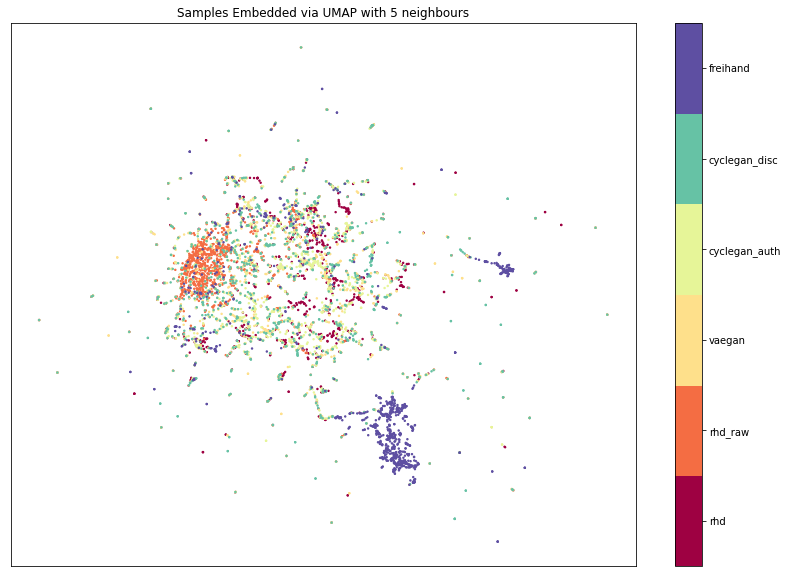

iteration 6


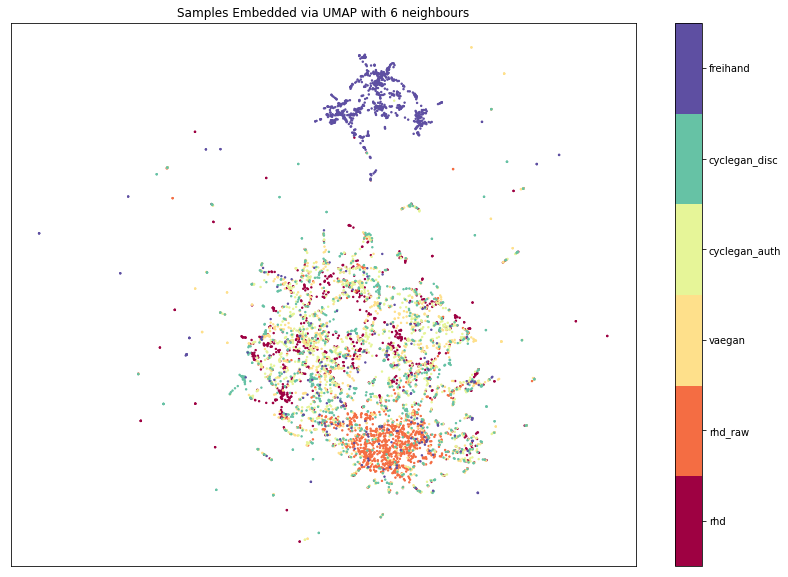

iteration 7


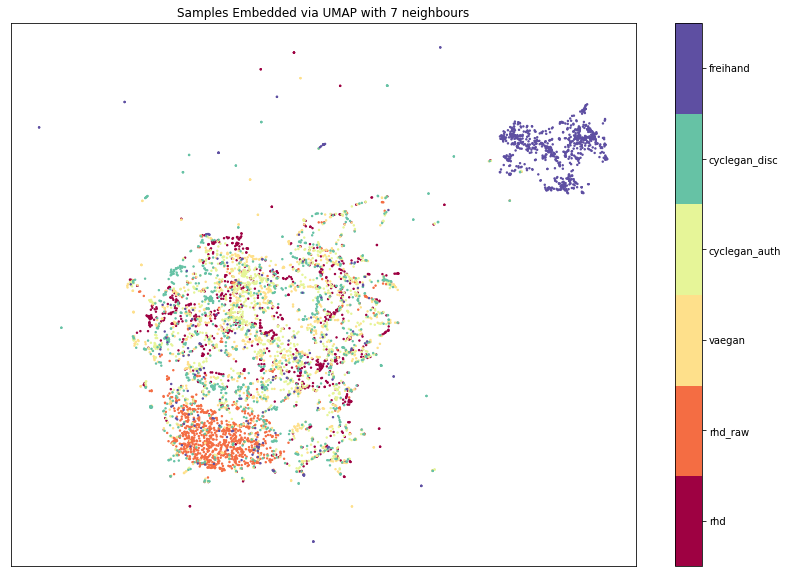

iteration 8


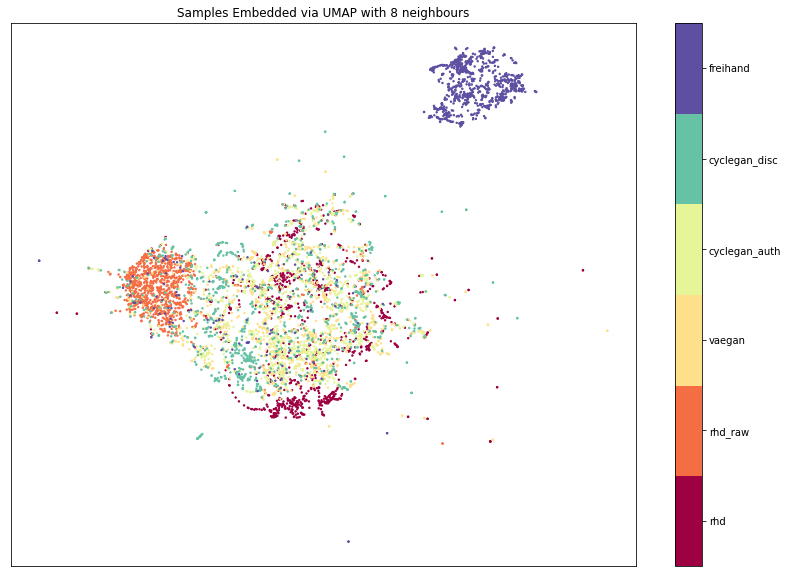

iteration 9


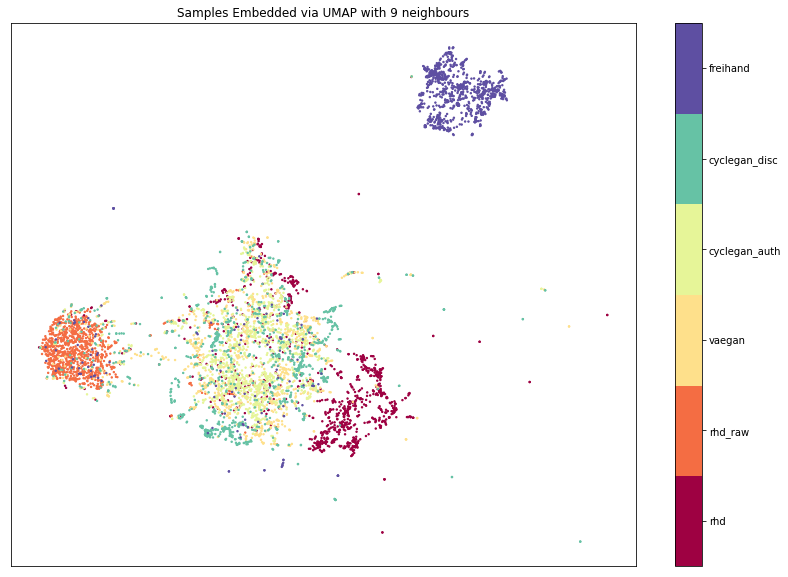

iteration 10


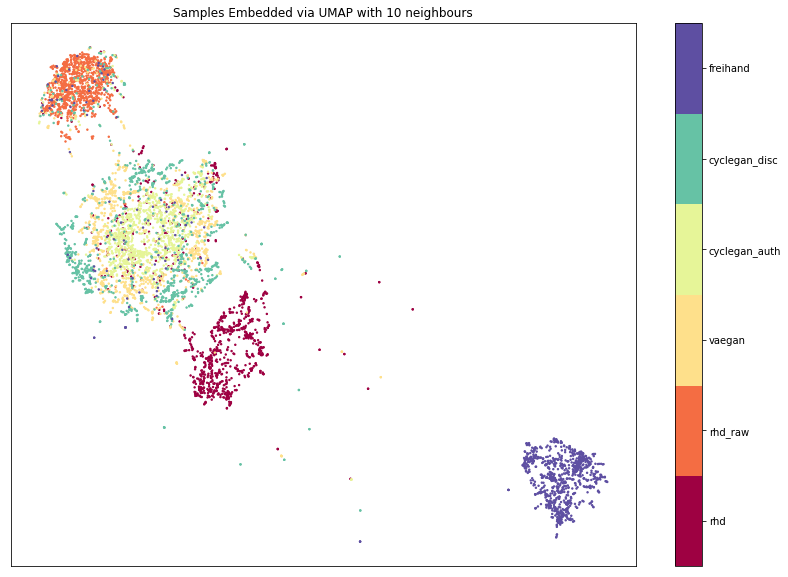

iteration 11


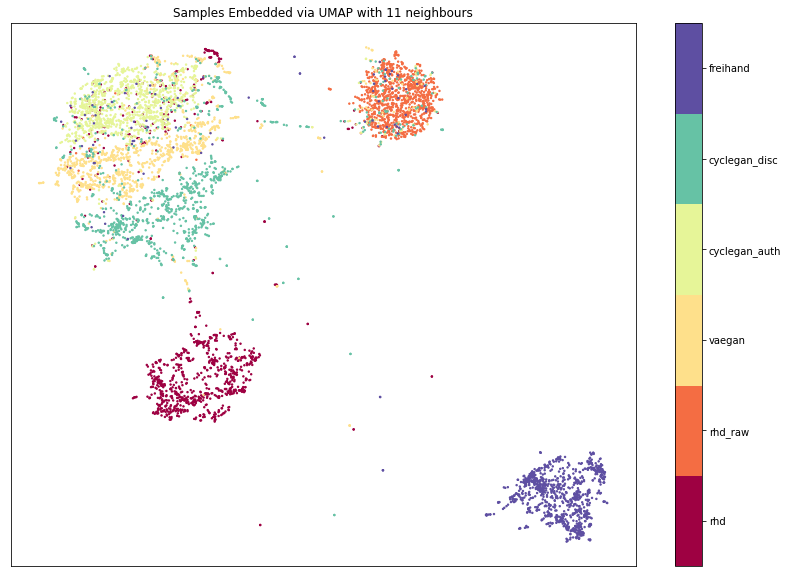

iteration 12


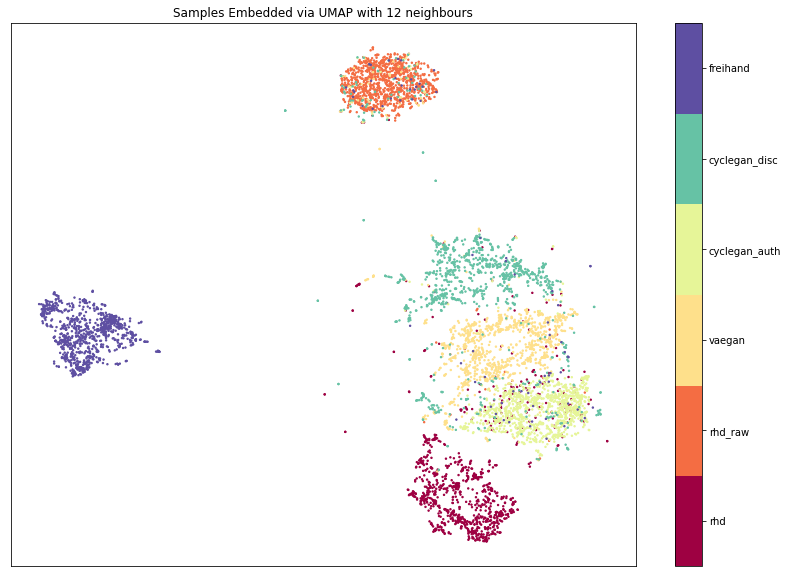

iteration 13


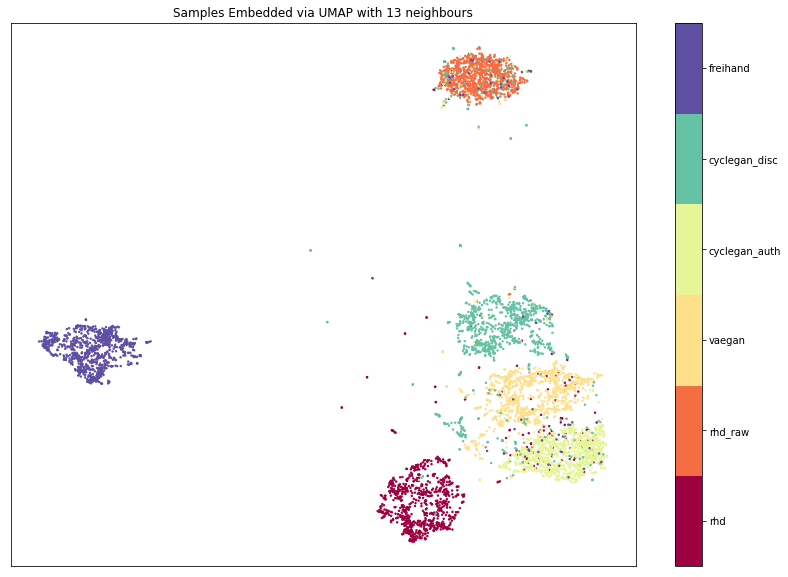

iteration 14


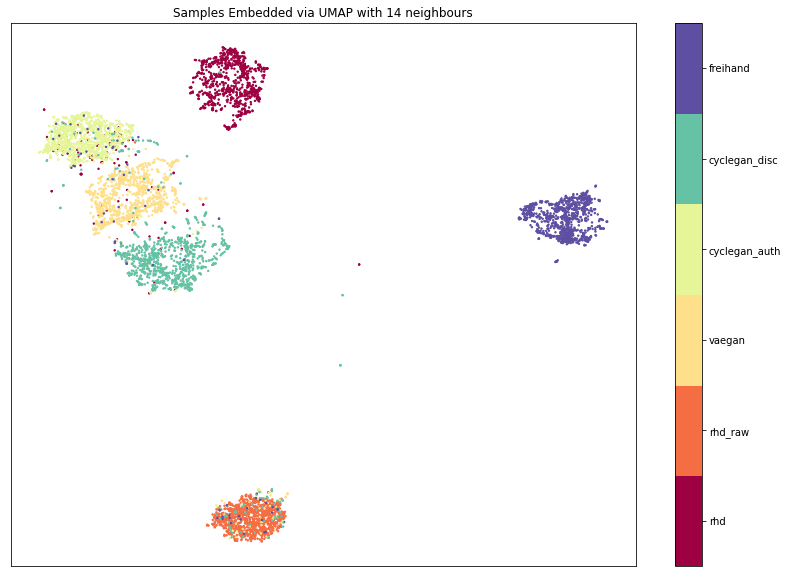

iteration 15


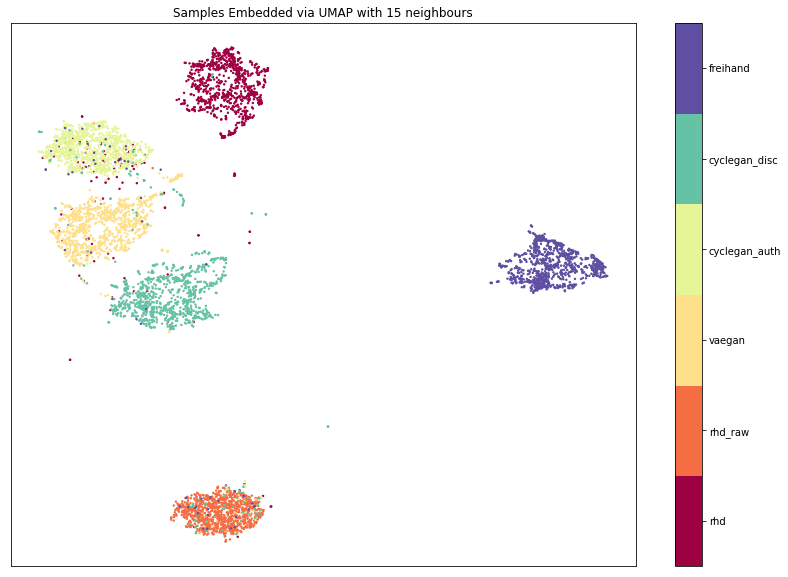

iteration 16


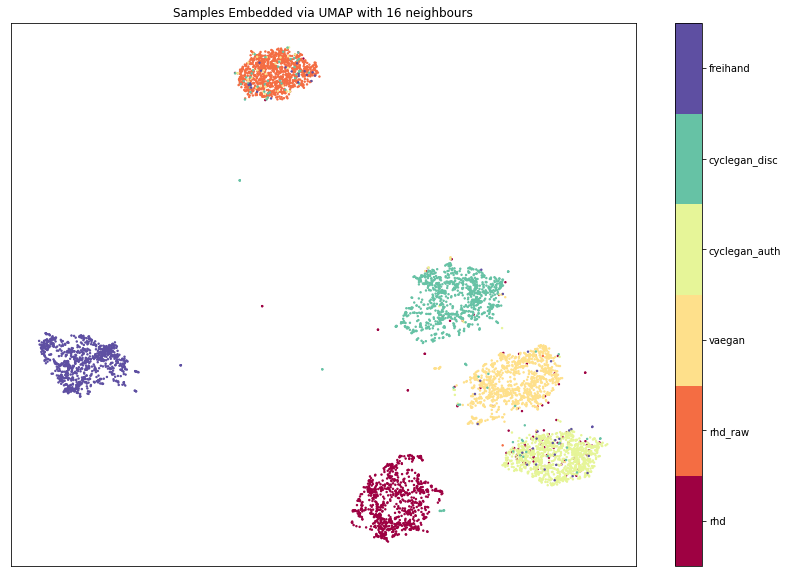

iteration 17


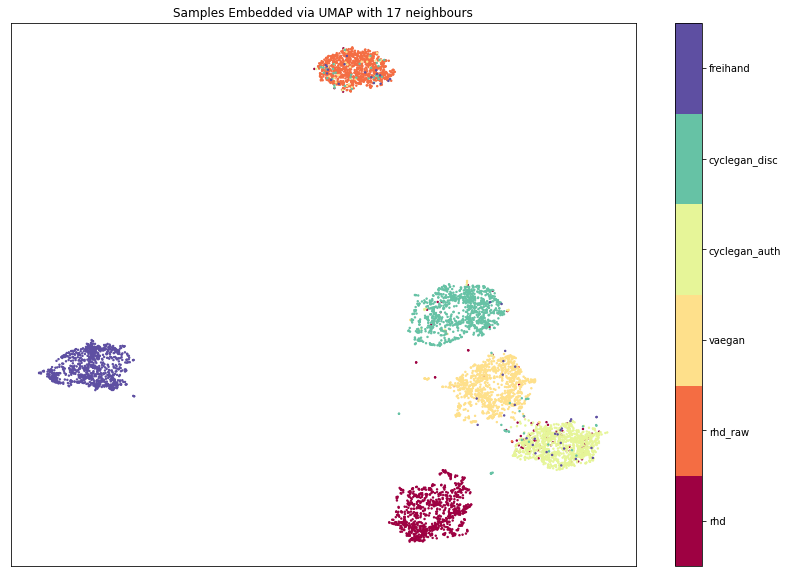

iteration 18


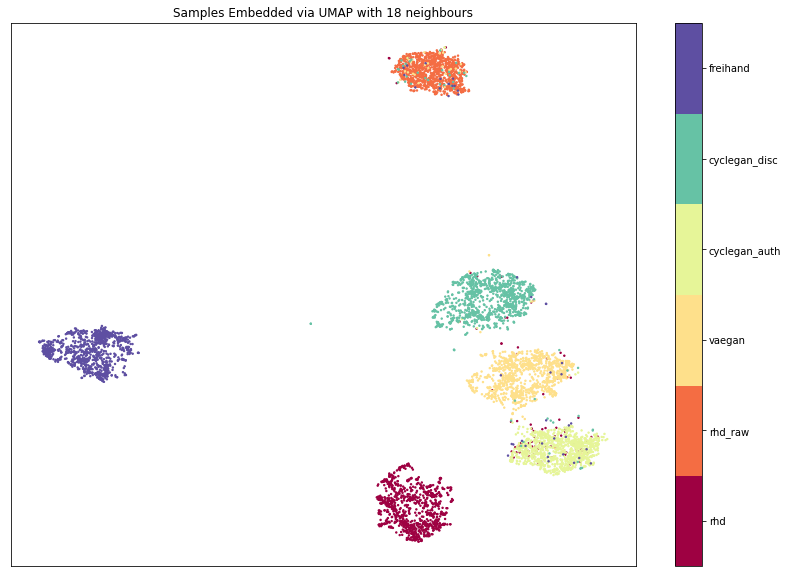

iteration 19


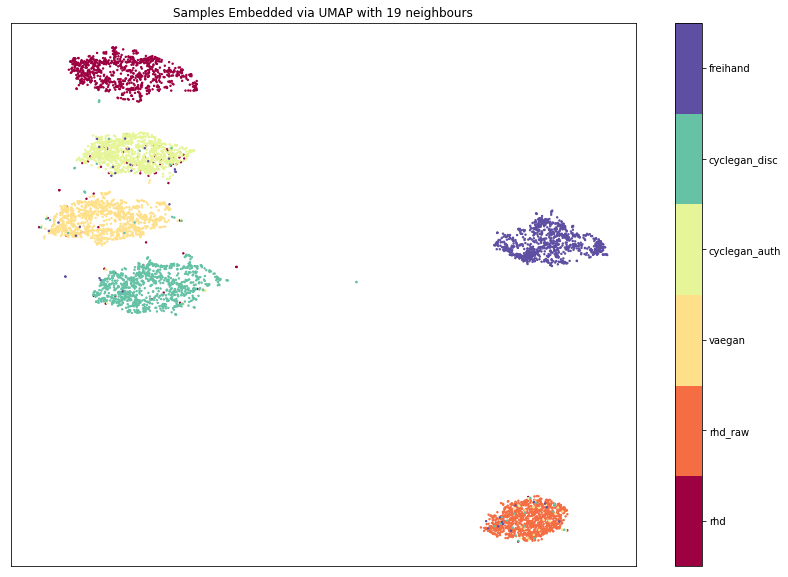

In [ ]:
for i in range(5,20):
    print(f'iteration {i}')
    model = umap.UMAP(n_neighbors=i)
    embedding = model.fit_transform(all.reshape(-1, 12288),y.squeeze())

    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*embedding.T, s=2, alpha=1.0, c=y.squeeze(), cmap='Spectral')
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
    cbar.set_ticks(np.arange(6))
    cbar.set_ticklabels(['rhd','rhd_raw','vaegan','cyclegan_auth','cyclegan_disc','freihand'])
    plt.title(f'Samples Embedded via UMAP with {i} neighbours')
    plt.show()